In [34]:
import numpy as np
import torch

def voc_target_transform(target):
    target_np = np.array(target).astype(np.uint8)
    target_np = np.where((target_np >= 0) & (target_np <= 20), target_np, 255)
    return torch.from_numpy(target_np).long()


In [35]:
import torch
import torch.nn as nn
import torchvision.models as models

class SegNet(nn.Module):
    def __init__(self, num_classes=21):
        super(SegNet, self).__init__()
        vgg16 = models.vgg16_bn(pretrained=True)
        features = vgg16.features
        
        self.enc_conv1 = features[:6]      
        self.enc_conv2 = features[7:13]     
        self.enc_conv3 = features[14:23]     
        self.enc_conv4 = features[24:33]     
        self.enc_conv5 = features[34:43]    

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        
        self.dec_conv5 = self._decoder_block(512, 512)
        self.dec_conv4 = self._decoder_block(512, 256)
        self.dec_conv3 = self._decoder_block(256, 128)
        self.dec_conv2 = self._decoder_block(128, 64)
        self.dec_conv1 = self._decoder_block(64, 64)
        
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)
    
    def _decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        x1 = self.enc_conv1(x)
        x1, idx1 = self.pool(x1)
        
        x2 = self.enc_conv2(x1)
        x2, idx2 = self.pool(x2)
        
        x3 = self.enc_conv3(x2)
        x3, idx3 = self.pool(x3)
        
        x4 = self.enc_conv4(x3)
        x4, idx4 = self.pool(x4)
        
        x5 = self.enc_conv5(x4)
        x5, idx5 = self.pool(x5)
        
        d5 = self.unpool(x5, idx5)
        d5 = self.dec_conv5(d5)
        
        d4 = self.unpool(d5, idx4)
        d4 = self.dec_conv4(d4)
        
        d3 = self.unpool(d4, idx3)
        d3 = self.dec_conv3(d3)
        
        d2 = self.unpool(d3, idx2)
        d2 = self.dec_conv2(d2)
        
        d1 = self.unpool(d2, idx1)
        d1 = self.dec_conv1(d1)
        
        out = self.final_conv(d1)
        return out

model_vgg = SegNet(num_classes=21)
print(model_vgg)


SegNet(
  (enc_conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc_conv2): Sequential(
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
  )
  (enc_conv3): Sequential(
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2d(256, eps=1e-05, momentum=0.1

In [36]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Lambda(voc_target_transform)
])

train_dataset = datasets.VOCSegmentation(
    root="./data",
    year="2012",
    image_set="train",
    download=True,
    transform=image_transform,
    target_transform=mask_transform
)

val_dataset = datasets.VOCSegmentation(
    root="./data",
    year="2012",
    image_set="val",
    download=True,
    transform=image_transform,
    target_transform=mask_transform
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)

sample_img, sample_mask = train_dataset[0]
print("Unique mask values from sample:", torch.unique(sample_mask))


Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Unique mask values from sample: tensor([  0,   1,  15, 255])


In [37]:
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model_vgg = SegNet(num_classes=21).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model_vgg.parameters(), lr=1e-4, weight_decay=1e-5)

num_epochs = 50 

for epoch in range(num_epochs):
    model_vgg.train()
    epoch_loss = 0.0
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model_vgg(images)  
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1} loss: {epoch_loss/len(train_loader):.4f}")


Using device: cuda


Epoch 1/50: 100%|██████████| 183/183 [00:33<00:00,  5.47it/s]


Epoch 1 loss: 2.3679


Epoch 2/50: 100%|██████████| 183/183 [00:33<00:00,  5.39it/s]


Epoch 2 loss: 1.6926


Epoch 3/50: 100%|██████████| 183/183 [00:34<00:00,  5.33it/s]


Epoch 3 loss: 1.3053


Epoch 4/50: 100%|██████████| 183/183 [00:34<00:00,  5.28it/s]


Epoch 4 loss: 1.0391


Epoch 5/50: 100%|██████████| 183/183 [00:34<00:00,  5.32it/s]


Epoch 5 loss: 0.8823


Epoch 6/50: 100%|██████████| 183/183 [00:34<00:00,  5.28it/s]


Epoch 6 loss: 0.7631


Epoch 7/50: 100%|██████████| 183/183 [00:34<00:00,  5.32it/s]


Epoch 7 loss: 0.6854


Epoch 8/50: 100%|██████████| 183/183 [00:34<00:00,  5.30it/s]


Epoch 8 loss: 0.6252


Epoch 9/50: 100%|██████████| 183/183 [00:34<00:00,  5.30it/s]


Epoch 9 loss: 0.5647


Epoch 10/50: 100%|██████████| 183/183 [00:34<00:00,  5.27it/s]


Epoch 10 loss: 0.5170


Epoch 11/50: 100%|██████████| 183/183 [00:34<00:00,  5.29it/s]


Epoch 11 loss: 0.5016


Epoch 12/50: 100%|██████████| 183/183 [00:34<00:00,  5.27it/s]


Epoch 12 loss: 0.4530


Epoch 13/50: 100%|██████████| 183/183 [00:35<00:00,  5.23it/s]


Epoch 13 loss: 0.4004


Epoch 14/50: 100%|██████████| 183/183 [00:34<00:00,  5.28it/s]


Epoch 14 loss: 0.3674


Epoch 15/50: 100%|██████████| 183/183 [00:34<00:00,  5.27it/s]


Epoch 15 loss: 0.3319


Epoch 16/50: 100%|██████████| 183/183 [00:34<00:00,  5.29it/s]


Epoch 16 loss: 0.3064


Epoch 17/50: 100%|██████████| 183/183 [00:34<00:00,  5.28it/s]


Epoch 17 loss: 0.2731


Epoch 18/50: 100%|██████████| 183/183 [00:34<00:00,  5.29it/s]


Epoch 18 loss: 0.2592


Epoch 19/50: 100%|██████████| 183/183 [00:34<00:00,  5.24it/s]


Epoch 19 loss: 0.2410


Epoch 20/50: 100%|██████████| 183/183 [00:34<00:00,  5.24it/s]


Epoch 20 loss: 0.2196


Epoch 21/50: 100%|██████████| 183/183 [00:34<00:00,  5.27it/s]


Epoch 21 loss: 0.2164


Epoch 22/50: 100%|██████████| 183/183 [00:34<00:00,  5.25it/s]


Epoch 22 loss: 0.2065


Epoch 23/50: 100%|██████████| 183/183 [00:34<00:00,  5.23it/s]


Epoch 23 loss: 0.1701


Epoch 24/50: 100%|██████████| 183/183 [00:34<00:00,  5.26it/s]


Epoch 24 loss: 0.1552


Epoch 25/50: 100%|██████████| 183/183 [00:34<00:00,  5.26it/s]


Epoch 25 loss: 0.1402


Epoch 26/50: 100%|██████████| 183/183 [00:34<00:00,  5.25it/s]


Epoch 26 loss: 0.1277


Epoch 27/50: 100%|██████████| 183/183 [00:35<00:00,  5.16it/s]


Epoch 27 loss: 0.1073


Epoch 28/50: 100%|██████████| 183/183 [00:34<00:00,  5.25it/s]


Epoch 28 loss: 0.1066


Epoch 29/50: 100%|██████████| 183/183 [00:34<00:00,  5.25it/s]


Epoch 29 loss: 0.0947


Epoch 30/50: 100%|██████████| 183/183 [00:34<00:00,  5.26it/s]


Epoch 30 loss: 0.1032


Epoch 31/50: 100%|██████████| 183/183 [00:34<00:00,  5.27it/s]


Epoch 31 loss: 0.1064


Epoch 32/50: 100%|██████████| 183/183 [00:34<00:00,  5.26it/s]


Epoch 32 loss: 0.0955


Epoch 33/50: 100%|██████████| 183/183 [00:35<00:00,  5.20it/s]


Epoch 33 loss: 0.0748


Epoch 34/50: 100%|██████████| 183/183 [00:35<00:00,  5.19it/s]


Epoch 34 loss: 0.0731


Epoch 35/50: 100%|██████████| 183/183 [00:34<00:00,  5.25it/s]


Epoch 35 loss: 0.0722


Epoch 36/50: 100%|██████████| 183/183 [00:34<00:00,  5.25it/s]


Epoch 36 loss: 0.0679


Epoch 37/50: 100%|██████████| 183/183 [00:34<00:00,  5.28it/s]


Epoch 37 loss: 0.0822


Epoch 38/50: 100%|██████████| 183/183 [00:34<00:00,  5.25it/s]


Epoch 38 loss: 0.0693


Epoch 39/50: 100%|██████████| 183/183 [00:34<00:00,  5.24it/s]


Epoch 39 loss: 0.0951


Epoch 40/50: 100%|██████████| 183/183 [00:34<00:00,  5.28it/s]


Epoch 40 loss: 0.0615


Epoch 41/50: 100%|██████████| 183/183 [00:34<00:00,  5.27it/s]


Epoch 41 loss: 0.0524


Epoch 42/50: 100%|██████████| 183/183 [00:34<00:00,  5.27it/s]


Epoch 42 loss: 0.0539


Epoch 43/50: 100%|██████████| 183/183 [00:34<00:00,  5.28it/s]


Epoch 43 loss: 0.0698


Epoch 44/50: 100%|██████████| 183/183 [00:34<00:00,  5.24it/s]


Epoch 44 loss: 0.0610


Epoch 45/50: 100%|██████████| 183/183 [00:34<00:00,  5.26it/s]


Epoch 45 loss: 0.0524


Epoch 46/50: 100%|██████████| 183/183 [00:34<00:00,  5.24it/s]


Epoch 46 loss: 0.0710


Epoch 47/50: 100%|██████████| 183/183 [00:34<00:00,  5.26it/s]


Epoch 47 loss: 0.0462


Epoch 48/50: 100%|██████████| 183/183 [00:34<00:00,  5.26it/s]


Epoch 48 loss: 0.0360


Epoch 49/50: 100%|██████████| 183/183 [00:34<00:00,  5.26it/s]


Epoch 49 loss: 0.0365


Epoch 50/50: 100%|██████████| 183/183 [00:34<00:00,  5.24it/s]

Epoch 50 loss: 0.0284


Pixel Accuracy: 0.8319


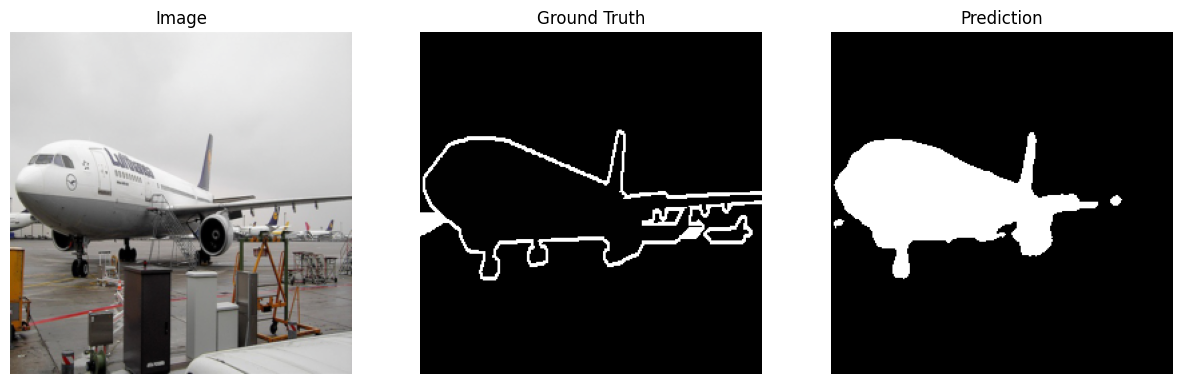

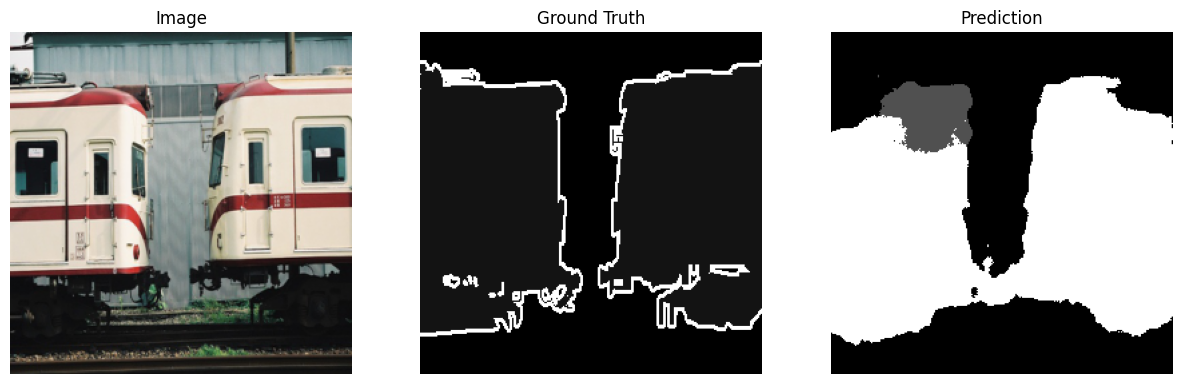

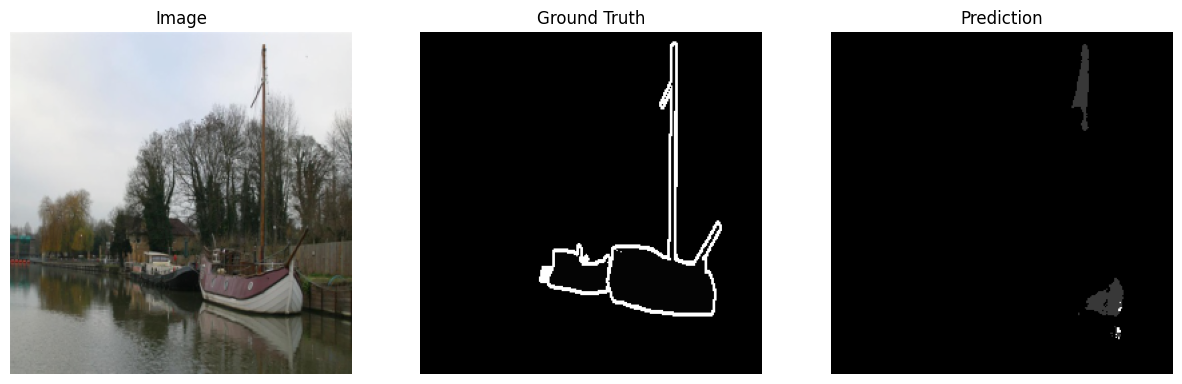

In [38]:
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader, device, num_classes=21):
    model.eval()
    total_correct = 0
    total_pixels = 0
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            total_correct += (preds == masks).sum().item()
            total_pixels += masks.numel()
    pixel_acc = total_correct / total_pixels
    print(f"Pixel Accuracy: {pixel_acc:.4f}")

def visualize_predictions(model, dataloader, device, imagenet_mean, imagenet_std, num_samples=3):
    model.eval()
    samples_shown = 0
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            for i in range(images.shape[0]):
                if samples_shown >= num_samples:
                    return
                img = images[i].cpu().permute(1, 2, 0).numpy()
                img = (img * np.array(imagenet_std)) + np.array(imagenet_mean)
                mask = masks[i].cpu().numpy()
                pred = preds[i].cpu().numpy()
                
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                axes[0].imshow(np.clip(img, 0, 1))
                axes[0].set_title("Image")
                axes[0].axis("off")
                
                axes[1].imshow(mask, cmap="gray")
                axes[1].set_title("Ground Truth")
                axes[1].axis("off")
                
                axes[2].imshow(pred, cmap="gray")
                axes[2].set_title("Prediction")
                axes[2].axis("off")
                
                plt.show()
                samples_shown += 1

evaluate_model(model_vgg, val_loader, device)

visualize_predictions(model_vgg, val_loader, device, imagenet_mean, imagenet_std, num_samples=3)


In [39]:
import torch
import torch.nn as nn
import torchvision.models as models

import torch
import torch.nn as nn
import torchvision.models as models

class SegNet_EfficientNet(nn.Module):
    def __init__(self, num_classes=21):
        super(SegNet_EfficientNet, self).__init__()
        efficientnet = models.efficientnet_b0(weights="IMAGENET1K_V1")
        self.encoder = efficientnet.features  
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1280, 512, kernel_size=3, stride=2, padding=1, output_padding=1),  # [B,512,16,16]
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),   # [B,256,32,32]
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),   # [B,128,64,64]
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),    # [B,64,128,128]
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(64, num_classes, kernel_size=3, stride=1, padding=1),              # [B,num_classes,128,128]
            nn.ConvTranspose2d(num_classes, num_classes, kernel_size=3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [40]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


def compute_iou(pred, target, num_classes=21):
    """
    Compute mean Intersection over Union (IoU) for all classes.
    """
    pred = pred.view(-1)
    target = target.view(-1)
    ious = []
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds & target_inds).sum().float()
        union = (pred_inds | target_inds).sum().float()
        if union == 0:
            ious.append(float("nan"))
        else:
            ious.append((intersection / union).item())
    return np.nanmean(ious)

def compute_dice(pred, target, smooth=1e-6):
    pred = pred.view(-1).float()
    target = target.view(-1).float()
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return dice.item()

def evaluate_model_metrics(model, dataloader, device, num_classes=21):

    model.eval()
    total_correct = 0
    total_pixels = 0
    total_iou = 0
    total_dice = 0
    num_batches = 0
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            total_correct += (preds == masks).sum().item()
            total_pixels += masks.numel()
            total_iou += compute_iou(preds, masks, num_classes)
            total_dice += compute_dice(preds, masks)
            num_batches += 1
    pixel_acc = total_correct / total_pixels
    mean_iou = total_iou / num_batches
    dice_score = total_dice / num_batches
    return pixel_acc, mean_iou, dice_score


def hyperparameter_tuning(train_loader, val_loader, device, hyperparams, model_type="vgg"):

    best_val_loss = float("inf")
    best_params = {}
    best_model = None
    best_metrics = None
    num_epochs_tune = hyperparams.get("num_epochs_tune", 10)
    criterion = nn.CrossEntropyLoss(ignore_index=255)
    
    for lr in hyperparams["learning_rates"]:
        for wd in hyperparams["weight_decays"]:
            for opt_type in hyperparams["optimizer_types"]:
                print(f"\nTraining with lr: {lr}, weight_decay: {wd}, optimizer: {opt_type}")
                if model_type == "vgg":
                    model = SegNet(num_classes=21).to(device)
                else:
                    model = SegNet_EfficientNet(num_classes=21).to(device)
                
                if opt_type.lower() == "adam":
                    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
                elif opt_type.lower() == "sgd":
                    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
                else:
                    raise ValueError(f"Unsupported optimizer type: {opt_type}")
                
                for epoch in range(num_epochs_tune):
                    model.train()
                    epoch_loss = 0.0
                    for images, masks in train_loader:
                        images = images.to(device)
                        masks = masks.to(device)
                        optimizer.zero_grad()
                        outputs = model(images)  
                        loss = criterion(outputs, masks)
                        loss.backward()
                        optimizer.step()
                        epoch_loss += loss.item()
                    avg_loss = epoch_loss / len(train_loader)
                    print(f"Epoch {epoch+1}/{num_epochs_tune} with lr {lr}, wd {wd}, optimizer {opt_type} loss: {avg_loss:.4f}")
                
                model.eval()
                val_loss = 0.0
                with torch.no_grad():
                    for images, masks in val_loader:
                        images = images.to(device)
                        masks = masks.to(device)
                        outputs = model(images)
                        loss = criterion(outputs, masks)
                        val_loss += loss.item()
                avg_val_loss = val_loss / len(val_loader)
                print(f"Validation loss with lr {lr}, wd {wd}, optimizer {opt_type}: {avg_val_loss:.4f}")
                
                pixel_acc, mean_iou, dice_score = evaluate_model_metrics(model, val_loader, device)
                print(f"Validation Metrics: Pixel Acc: {pixel_acc:.4f}, Mean IoU: {mean_iou:.4f}, Dice: {dice_score:.4f}")
                
                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    best_params = {"learning_rate": lr, "weight_decay": wd, "optimizer": opt_type}
                    best_model = model
                    best_metrics = (pixel_acc, mean_iou, dice_score)
                    
    print(f"\nBest {model_type.capitalize()}-based SegNet Params: {best_params}, Validation Loss: {best_val_loss:.4f}")
    print(f"Best Metrics: Pixel Acc: {best_metrics[0]:.4f}, Mean IoU: {best_metrics[1]:.4f}, Dice: {best_metrics[2]:.4f}")
    
    return best_model, best_params, best_val_loss, best_metrics

hyperparams = {
    "learning_rates": [1e-4, 5e-4, 1e-3],
    "weight_decays": [1e-5, 1e-4],
    "optimizer_types": ["adam", "sgd"],
    "num_epochs_tune": 10  
}

best_model_vgg, best_params_vgg, best_val_loss_vgg, best_metrics_vgg = hyperparameter_tuning(
    train_loader, val_loader, device, hyperparams, model_type="vgg"
)
print("\nBest VGG-based SegNet:")
print("Best Hyperparameters:", best_params_vgg)
print(f"Validation Loss: {best_val_loss_vgg:.4f}")
print(f"Pixel Accuracy: {best_metrics_vgg[0]:.4f}, Mean IoU: {best_metrics_vgg[1]:.4f}, Dice: {best_metrics_vgg[2]:.4f}")

best_model_eff, best_params_eff, best_val_loss_eff, best_metrics_eff = hyperparameter_tuning(
    train_loader, val_loader, device, hyperparams, model_type="efficientnet"
)
print("\nBest EfficientNet-based SegNet:")
print("Best Hyperparameters:", best_params_eff)
print(f"Validation Loss: {best_val_loss_eff:.4f}")
print(f"Pixel Accuracy: {best_metrics_eff[0]:.4f}, Mean IoU: {best_metrics_eff[1]:.4f}, Dice: {best_metrics_eff[2]:.4f}")



Training with lr: 0.0001, weight_decay: 1e-05, optimizer: adam
Epoch 1/10 with lr 0.0001, wd 1e-05, optimizer adam loss: 2.3725
Epoch 2/10 with lr 0.0001, wd 1e-05, optimizer adam loss: 1.6350
Epoch 3/10 with lr 0.0001, wd 1e-05, optimizer adam loss: 1.2273
Epoch 4/10 with lr 0.0001, wd 1e-05, optimizer adam loss: 0.9839
Epoch 5/10 with lr 0.0001, wd 1e-05, optimizer adam loss: 0.8310
Epoch 6/10 with lr 0.0001, wd 1e-05, optimizer adam loss: 0.7335
Epoch 7/10 with lr 0.0001, wd 1e-05, optimizer adam loss: 0.6741
Epoch 8/10 with lr 0.0001, wd 1e-05, optimizer adam loss: 0.6078
Epoch 9/10 with lr 0.0001, wd 1e-05, optimizer adam loss: 0.5517
Epoch 10/10 with lr 0.0001, wd 1e-05, optimizer adam loss: 0.4992
Validation loss with lr 0.0001, wd 1e-05, optimizer adam: 0.6613
Validation Metrics: Pixel Acc: 0.7835, Mean IoU: 0.1669, Dice: 8.6597

Training with lr: 0.0001, weight_decay: 1e-05, optimizer: sgd
Epoch 1/10 with lr 0.0001, wd 1e-05, optimizer sgd loss: 2.8613
Epoch 2/10 with lr 0.00

In [41]:
import numpy as np
import torch

def compute_iou(pred, target, num_classes=21):
    pred = pred.view(-1)
    target = target.view(-1)
    ious = []
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds & target_inds).sum().float()
        union = (pred_inds | target_inds).sum().float()
        if union == 0:
            ious.append(float("nan"))
        else:
            ious.append((intersection / union).item())
    return np.nanmean(ious)

def compute_dice(pred, target, smooth=1e-6):

    pred = pred.view(-1).float()
    target = target.view(-1).float()
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return dice.item()


In [42]:
def evaluate_model_metrics(model, dataloader, device, num_classes=21):

    model.eval()
    total_correct = 0
    total_pixels = 0
    total_iou = 0
    total_dice = 0
    num_batches = 0
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            total_correct += (preds == masks).sum().item()
            total_pixels += masks.numel()
            total_iou += compute_iou(preds, masks, num_classes)
            total_dice += compute_dice(preds, masks)
            num_batches += 1
    pixel_acc = total_correct / total_pixels
    mean_iou = total_iou / num_batches
    dice_score = total_dice / num_batches
    return pixel_acc, mean_iou, dice_score

pixel_acc_vgg, mean_iou_vgg, dice_vgg = evaluate_model_metrics(best_model_vgg, val_loader, device)
pixel_acc_eff, mean_iou_eff, dice_eff = evaluate_model_metrics(best_model_eff, val_loader, device)


In [43]:
import time

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def measure_inference_speed(model, dataloader, device, num_samples=10):
    model.eval()
    times = []
    with torch.no_grad():
        for i, (images, _) in enumerate(dataloader):
            if i >= num_samples:
                break
            images = images.to(device)
            start_time = time.time()
            _ = model(images)
            times.append(time.time() - start_time)
    avg_time = sum(times) / len(times)
    fps = 1 / avg_time
    return fps


In [44]:
vgg_params = count_parameters(best_model_vgg)
eff_params = count_parameters(best_model_eff)
vgg_fps = measure_inference_speed(best_model_vgg, val_loader, device)
eff_fps = measure_inference_speed(best_model_eff, val_loader, device)


In [45]:
print("\nModel Comparison Summary:")
print("| Model                     | Parameters      | FPS    | Pixel Acc | Mean IoU | Dice/F1 |")
print("|---------------------------|-----------------|--------|-----------|----------|---------|")
print(f"| VGG-based SegNet          | {vgg_params:,}   | {vgg_fps:.2f} | {pixel_acc_vgg:.4f}   | {mean_iou_vgg:.4f}  | {dice_vgg:.4f} |")
print(f"| EfficientNet-based SegNet | {eff_params:,}   | {eff_fps:.2f} | {pixel_acc_eff:.4f}   | {mean_iou_eff:.4f}  | {dice_eff:.4f} |")



Model Comparison Summary:
| Model                     | Parameters      | FPS    | Pixel Acc | Mean IoU | Dice/F1 |
|---------------------------|-----------------|--------|-----------|----------|---------|
| VGG-based SegNet          | 21,845,397   | 180.08 | 0.7835   | 0.1669  | 8.6597 |
| EfficientNet-based SegNet | 11,471,143   | 84.16 | 0.7626   | 0.1558  | 8.0371 |


In [46]:
test_loader = val_loader 

print("\nTest Evaluation for VGG-based SegNet:")
evaluate_model(best_model_vgg, test_loader, device)

print("\nTest Evaluation for EfficientNet-based SegNet:")
evaluate_model(best_model_eff, test_loader, device)



Test Evaluation for VGG-based SegNet:
Pixel Accuracy: 0.7835

Test Evaluation for EfficientNet-based SegNet:
Pixel Accuracy: 0.7626
